#Import libraies and packages

In [1]:
pip install ray torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 4.1 MB 49.5 MB/s 
     |████████████████████████████████| 8.8 MB 38.5 MB/s 
     |████████████████████████████████| 468 kB 56.0 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.50.0
    Uninstalling grpcio-1.50.0:
      Successfully uninstalled grpcio-1.50.0


In [2]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest import ConcurrencyLimiter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  if sys.path[0] == '':


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Seconda try

In [250]:
class ConvNet(nn.Module):
    def __init__(self, dim):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.dim=dim
        self.conv1 = nn.Conv1d(30, 1, 5)
        self.fc = nn.Linear(8, 1)
        self.item_embedding = torch.nn.Embedding(num_embeddings=39, embedding_dim=30)
    def forward(self, x):
        x = torch.tensor(x).to(torch.int)
        x = self.item_embedding(x)
        x = x.squeeze(1)
        x = F.relu(F.max_pool1d(self.conv1(x), 3))
        # x = x.view(-1, 30)
        x = self.fc(x)
        # predictions = tf.keras.layers.Dense(1,tf.keras.layers.Activation('sigmoid'))(x)
        x = F.sigmoid(x).squeeze(1)
        return x

In [210]:
from ray import air, tune
import random
from torch.utils.data import DataLoader
import tensorflow as tf


In [255]:
def train_mnist(config):
    # Data Setup
    list_data_0=[]
    list_data_1=[]
    path ='/content/drive/MyDrive/UPM/Internship/Clinical_data_and_RNA_30_Features_PFS.csv'
    data_frame = pd.read_csv(path)
    
    X = data_frame[['AC005307.1', 'ATP5G2P1', 'DLGAP4', 'EIF4A1P9', 'FAM172BP', 'FAM224A', 'GJA9', 'GPR155', 'GYPE', 'IL25', 'KLHL5', 'LANCL1-AS1', 'LEMD1', 'PCMT1', 'RP11-120J4.1', 'RP11-20G6.3', 'RP11-349G13.2', 'RP11-374M1.2', 'RP11-536C10.21', 'RP11-95G17.2', 'RP11-96O20.4', 'RP5-827C21.1', 'RPS12P26', 'SDR42E1', 'SNORD113-5', 'TARBP2', 'TRAV41', 'TRIM43B', 'VN2R17P', 'XPC']] #Seleccionamos todas las columnas quitando la columna Unnamed (id de la fila ) y la columna Target.
    Y=[]
    for i in range (len(data_frame)):
      if data_frame.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
          Y.append(0)
      else:
          Y.append(1)# If PFS is over 3 months, I will consider it as Responder (R)

    for g in range(len(X)):
      b=[]
      for i in X.iloc[g].to_numpy():
        a=[]
        a.append(i)
        b.append(a)
      x = torch.tensor([b], dtype=torch.float).reshape([-1])
      y = torch.tensor([Y[g]], dtype=torch.float).reshape([-1, 1])
      if y == 0:
        list_data_0.append([x, y])
      else:
        list_data_1.append([x, y])
    print(list_data_0[0])

    random.shuffle(list_data_0)
    random.shuffle(list_data_1)

    train_dataset = list_data_0[0:72]
    test_dataset = list_data_0[72:86]
    train_dataset = train_dataset + list_data_1[0:81]
    test_dataset = test_dataset + list_data_1[81:97]
    random.shuffle(train_dataset)
    random.shuffle(test_dataset)
    print(f'Number of training patients: {len(train_dataset)}')
    print(f'Number of test patients: {len(test_dataset)}')
    cont = 0
    cont1=0
    for i in train_dataset:
        if i[1] == 0:
            cont+=1
    for i in test_dataset:
        if i[1] == 0:
            cont1+=1
    print("Negative cases from train: " + str(cont) + " of " + str(len(train_dataset)) + " = " + str(cont/len(train_dataset)))
    print("Negative cases from test: " + str(cont1) + " of " + str(len(test_dataset)) + " = " + str(cont1/len(test_dataset)))
    print("It should be 46.9")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    for step, data in enumerate(train_loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {len(data[0])}')
        # print(data)
        print()

    # Create model
    model = ConvNet(dim = len(data[0]))

    # Compile model with losses and metrics
    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    # optimizer=torch.optim.Adam(model.parameters(), lr =config['lr'])

    for i in range(100):
            loss = train(model, optimizer, train_loader)
            acc = test(model, test_loader)

            # Send the current training result back to Tune
            tune.report(mean_accuracy=acc, loss = loss)

            if i % 5 == 0:
                # This saves the model to the trial directory
                torch.save(model.state_dict(), "model.pth")


In [238]:
def train(model, optimizer, train_loader):
    model.train()
    criterion = nn.BCELoss()
    loss_all = 0
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        output = model(inputs.squeeze(1))
        loss = criterion(output, labels.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all += loss.item()

    return loss_all / len(train_loader)


def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        inputs, labels = data
        output = model(inputs.squeeze(1))
        for i in range(len(output)):
            if output[i]>0.5:
                output[i]=1
            else:
                output[i]=0
            if output[i]==labels[i]:
                correct=correct+1
    # print("Correct: "+str(correct) +" of "+str(len(loader.dataset)))
    return correct / len(loader.dataset)

In [256]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", 1e-10, 0.1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=10,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()


2022-11-03 16:45:55,161	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,lr,momentum,acc,iter,total time (s),loss
train_mnist_fc22749a,TERMINATED,172.28.0.2:12692,1.03011,0.413222,0.464286,100,1.5674,0.439536
train_mnist_fddde6a2,TERMINATED,172.28.0.2:12729,1.05828,0.129692,0.785714,100,1.56566,0.0920437
train_mnist_fde1fd28,TERMINATED,172.28.0.2:12692,1.05974,0.377199,0.535714,100,1.46364,47.25
train_mnist_fecef4a2,TERMINATED,172.28.0.2:12692,1.06955,0.297223,0.535714,100,1.54155,46.4375
train_mnist_ffd075ec,TERMINATED,172.28.0.2:12692,1.04268,0.494867,0.535714,100,1.52037,0.69459
train_mnist_00bdd044,TERMINATED,172.28.0.2:12729,1.02438,0.319189,0.535714,100,1.52783,48.875
train_mnist_00c1186c,TERMINATED,172.28.0.2:12692,1.04373,0.338332,0.464286,100,1.52276,52.6912
train_mnist_01a85740,TERMINATED,172.28.0.2:12729,1.05596,0.418169,0.535714,100,1.49041,46.4375
train_mnist_01ad6c1c,TERMINATED,172.28.0.2:12692,1.07943,0.866498,0.464286,100,1.52691,51.9375
train_mnist_0292bf06,TERMINATED,172.28.0.2:12729,1.0586,0.76015,0.535714,100,1.48192,47.25


Result for train_mnist_fc22749a:
  date: 2022-11-03_16-45-58
  done: false
  experiment_id: aaf35a4a45b04e61ad946ce28859e6ab
  hostname: 8573c8d12acf
  iterations_since_restore: 1
  loss: 0.8062023321787516
  mean_accuracy: 0.5357142857142857
  node_ip: 172.28.0.2
  pid: 12692
  time_since_restore: 0.17554497718811035
  time_this_iter_s: 0.17554497718811035
  time_total_s: 0.17554497718811035
  timestamp: 1667493958
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc22749a
  warmup_time: 0.005669116973876953
  
(train_mnist pid=12692) [tensor([21.0554, 21.3003, 34.4118, 26.7616, 21.6293, 21.1237, 29.2922, 30.7290,
(train_mnist pid=12692)         23.0570, 21.0804, 33.7957, 21.3999, 29.7076, 33.5030, 21.4144, 21.3655,
(train_mnist pid=12692)         21.0655, 21.2466, 28.4511, 21.1485, 21.1875, 23.0343, 30.1914, 22.8373,
(train_mnist pid=12692)         21.3274, 30.3542, 22.2215, 21.9744, 21.1286, 31.6356]), tensor([[0.]])]
(train_mnist pid=12692) Number of training patient

(train_mnist pid=12692) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=12692)   import ray._private.utils
(train_mnist pid=12692) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=12692)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Result for train_mnist_fc22749a:
  date: 2022-11-03_16-45-59
  done: true
  experiment_id: aaf35a4a45b04e61ad946ce28859e6ab
  experiment_tag: 1_lr=1.0301,momentum=0.4132
  hostname: 8573c8d12acf
  iterations_since_restore: 100
  loss: 0.439536194006602
  mean_accuracy: 0.4642857142857143
  node_ip: 172.28.0.2
  pid: 12692
  time_since_restore: 1.5674006938934326
  time_this_iter_s: 0.018124818801879883
  time_total_s: 1.5674006938934326
  timestamp: 1667493959
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: fc22749a
  warmup_time: 0.005669116973876953
  
Result for train_mnist_fde1fd28:
  date: 2022-11-03_16-45-59
  done: false
  experiment_id: aaf35a4a45b04e61ad946ce28859e6ab
  hostname: 8573c8d12acf
  iterations_since_restore: 1
  loss: 0.7079320549964905
  mean_accuracy: 0.42857142857142855
  node_ip: 172.28.0.2
  pid: 12692
  time_since_restore: 0.07716822624206543
  time_this_iter_s: 0.07716822624206543
  time_total_s: 0.07716822624206543
  timestamp: 1667493959

(train_mnist pid=12729) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=12729)   import ray._private.utils
(train_mnist pid=12729) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=12729)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Result for train_mnist_fecef4a2:
  date: 2022-11-03_16-46-02
  done: true
  experiment_id: aaf35a4a45b04e61ad946ce28859e6ab
  experiment_tag: 4_lr=1.0695,momentum=0.2972
  hostname: 8573c8d12acf
  iterations_since_restore: 100
  loss: 46.4375
  mean_accuracy: 0.5357142857142857
  node_ip: 172.28.0.2
  pid: 12692
  time_since_restore: 1.541553258895874
  time_this_iter_s: 0.013341188430786133
  time_total_s: 1.541553258895874
  timestamp: 1667493962
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: fecef4a2
  warmup_time: 0.005669116973876953
  
Result for train_mnist_fddde6a2:
  date: 2022-11-03_16-46-02
  done: true
  experiment_id: c1115d5a9abe49c7b591e207d9125a4c
  experiment_tag: 2_lr=1.0583,momentum=0.1297
  hostname: 8573c8d12acf
  iterations_since_restore: 100
  loss: 0.09204366554816563
  mean_accuracy: 0.7857142857142857
  node_ip: 172.28.0.2
  pid: 12729
  time_since_restore: 1.565661907196045
  time_this_iter_s: 0.012562990188598633
  time_total_s: 1.5656619

2022-11-03 16:46:07,765	INFO tune.py:759 -- Total run time: 12.62 seconds (12.34 seconds for the tuning loop).


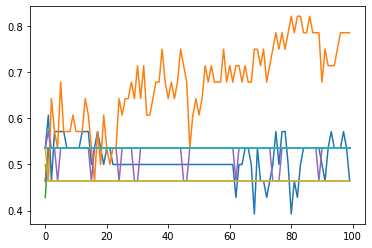

In [257]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]